### Imports

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import altair as alt
from prophet import Prophet
from sklearn.metrics import silhouette_score, average_precision_score, f1_score, classification_report, mean_absolute_error, mean_absolute_percentage_error

c:\Users\Josh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importation des données

In [4]:
df = pd.read_csv('../data/default_nyc_taxi.csv')
df.head()

,timestamp,value,class
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


### Préparation des données

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

timestamp    datetime64[ns]
value                 int64
class                 int64
dtype: object

In [6]:
#rename columns according to the prophet standards
df_prophet = df[['timestamp', 'value']].rename(columns={'timestamp':'ds','value':'y'})

### FB Prophet

In [7]:
#build Prophet model
#Prophet(daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=False, seasonality_mode='additive', interval_width=0.95, changepoint_range=0.8)
prophet = Prophet(changepoint_range=0.95)
prophet.fit(df_prophet)

18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
#make predictions
future = prophet.make_future_dataframe(periods=100)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-07-01 00:00:00,13157.872862,8295.636163,17856.838948
1,2014-07-01 00:30:00,11809.799207,6713.377329,16533.697196
2,2014-07-01 01:00:00,10295.745610,5294.748946,15439.213610
3,2014-07-01 01:30:00,8602.915176,3668.886915,13337.988365
4,2014-07-01 02:00:00,6780.901419,1817.752924,11889.382729


In [9]:
results = pd.merge(df_prophet[['ds', 'y']], forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on=['ds'], how='outer')
results.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2014-07-01 00:00:00,10844.0,13157.872862,8295.636163,17856.838948
1,2014-07-01 00:30:00,8127.0,11809.799207,6713.377329,16533.697196
2,2014-07-01 01:00:00,6210.0,10295.745610,5294.748946,15439.213610
3,2014-07-01 01:30:00,4656.0,8602.915176,3668.886915,13337.988365
4,2014-07-01 02:00:00,3820.0,6780.901419,1817.752924,11889.382729


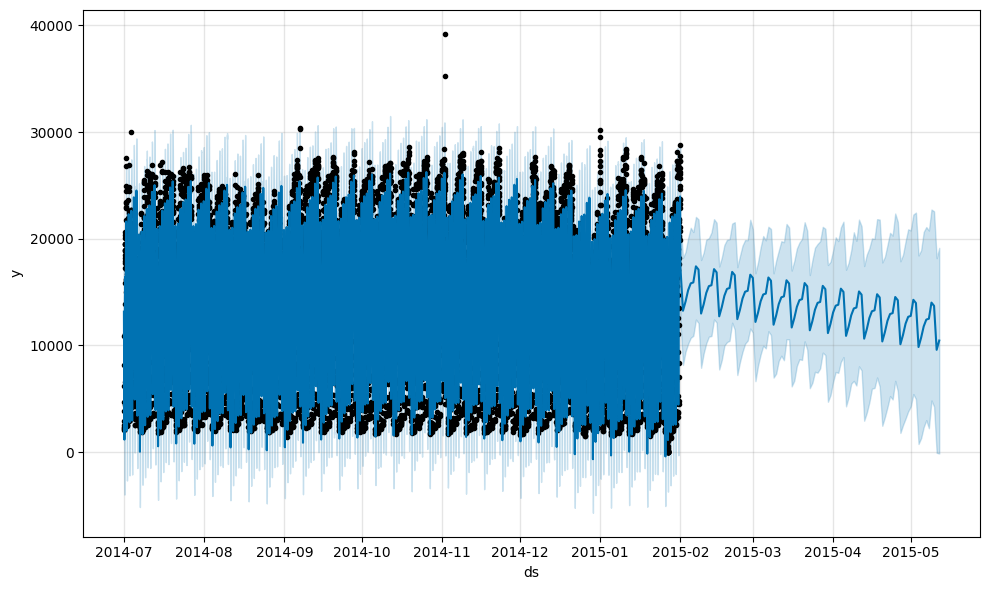

In [10]:
#plot predicted values
fig1 = prophet.plot(forecast)

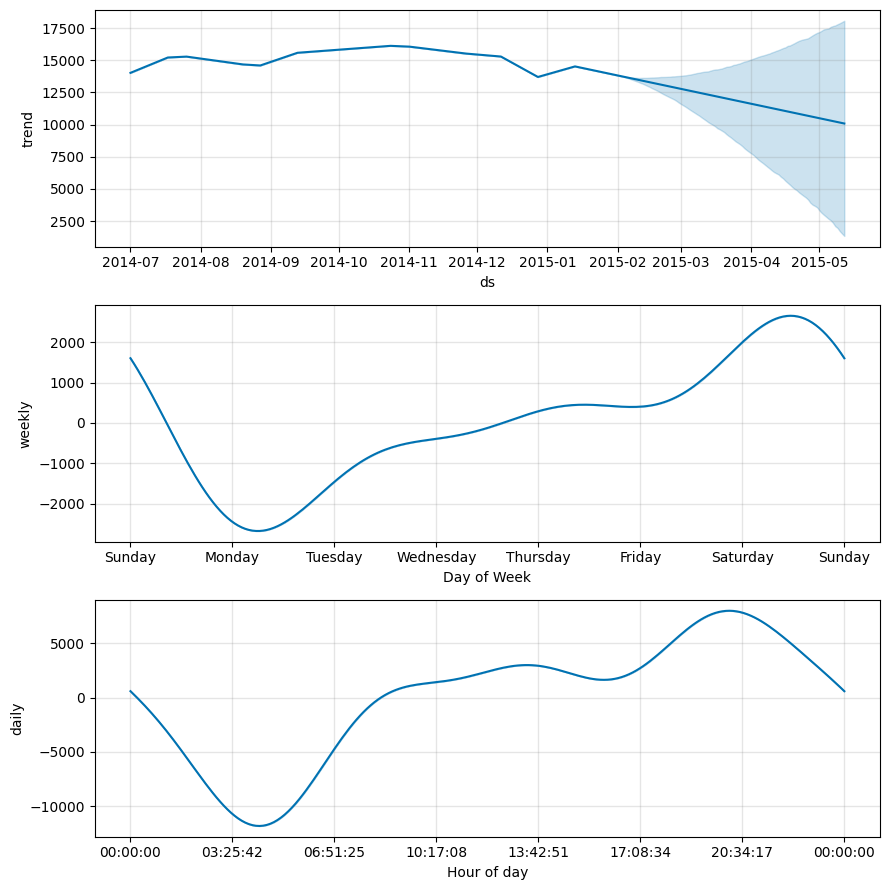

In [11]:
#analyze weekly and daily trends
comp = prophet.plot_components(forecast)

In [12]:
results['error'] = results['y'] - results['yhat']
results['uncertainity'] = results['yhat_upper'] - results['yhat_lower']
results[results['error'].abs() > 1.5*results['uncertainity']] # anomalies

,ds,y,yhat,yhat_lower,yhat_upper,error,uncertainity
5954,2014-11-02 01:00:00,39197.0,15110.140246,10206.733981,19953.598939,24086.859754,9746.864959
5955,2014-11-02 01:30:00,35212.0,13286.639608,8885.841134,18177.178447,21925.360392,9291.337312
8833,2015-01-01 00:30:00,29547.0,13415.997339,8881.849396,18503.908214,16131.002661,9622.058817
8834,2015-01-01 01:00:00,30236.0,11871.603539,7163.624049,16670.088476,18364.396461,9506.464427
8835,2015-01-01 01:30:00,28348.0,10148.562332,5353.183648,14975.775619,18199.437668,9622.591970
8836,2015-01-01 02:00:00,26264.0,8296.503432,3386.177396,13282.611349,17967.496568,9896.433954
8837,2015-01-01 02:30:00,25243.0,6434.465789,1565.288388,11528.276079,18808.534211,9962.987692
8838,2015-01-01 03:00:00,23117.0,4737.966736,-19.424303,9492.207436,18379.033264,9511.631740
8839,2015-01-01 03:30:00,21017.0,3408.187713,-1140.449667,7812.824730,17608.812287,8953.274397
8840,2015-01-01 04:00:00,18170.0,2630.312317,-2064.090238,7594.861363,15539.687683,9658.951601


In [13]:
# real anomalies
results['class'] = df['class']
results['class'].value_counts(dropna=False)

0.0    9290
1.0    1030
NaN     100
Name: class, dtype: int64

In [14]:
# anomalies found
results['anomaly'] = results.apply(lambda x: 1 if (np.abs(x['error']) > 1.5*x['uncertainity']) else 0, axis=1)
results['anomaly'].value_counts()

0    10402
1       18
Name: anomaly, dtype: int64

In [15]:
#display anomalies
results['anomaly_colors'] = results.apply(lambda x: 'Yes - found' if  (x['anomaly'] == 1) else ('Yes - real' if (x['class'] == 1) else 'No'), axis=1)
results = results[:-100].reset_index() #enlever les predictions

fig = px.scatter(results, x='ds', y='y',
                color='anomaly_colors', color_discrete_map = {'Yes - found': 'red', 'Yes - real': 'yellow', 'No': 'blue'},
                title='Anomalies detected by FB Prophet', labels={'ds':'Datetime', 'y':'The Number of NYC taxi passengers'})

"""
fig.update_xaxes(rangeslider_visible=True,
                rangeselector=dict(buttons=list([
                    dict(count=1, label='1y', step='year', stepmode='backward'),
                    dict(count=2, label='2y', step='year', stepmode='backward'),
                    dict(count=3, label='3y', step='year', stepmode='backward'),
                    dict(step='all')
                ])))
"""

fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('anomaly_colors=No<br>Datetime=' ... 'passengers=%{y}<extra></extra>'),
              'legendgroup': 'No',
              'marker': {'color': 'blue', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'No',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2014, 7, 1, 0, 0),
                          datetime.datetime(2014, 7, 1, 0, 30),
                          datetime.datetime(2014, 7, 1, 1, 0), ...,
                          datetime.datetime(2015, 1, 31, 22, 30),
                          datetime.datetime(2015, 1, 31, 23, 0),
                          datetime.datetime(2015, 1, 31, 23, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([10844.,  8127.,  6210., ..., 27309., 26591., 26288.]),
              'yaxis': 'y'},
             {'hovertemplate': ('anomaly_colors=Yes - real<br>D' ... 'passengers=%{y}<extra></extra>'),
              'legendgroup': 'Yes - real',
              'marker': {'color': 'yellow', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Yes - real',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2014, 10, 30, 16, 0),
                          datetime.datetime(2014, 10, 30, 16, 30),
                          datetime.datetime(2014, 10, 30, 17, 0), ...,
                          datetime.datetime(2015, 1, 29, 2, 30),
                          datetime.datetime(2015, 1, 29, 3, 0),
                          datetime.datetime(2015, 1, 29, 3, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([14604., 13367., 16382., ...,  2822.,  2379.,  2121.]),
              'yaxis': 'y'},
             {'hovertemplate': ('anomaly_colors=Yes - found<br>' ... 'passengers=%{y}<extra></extra>'),
              'legendgroup': 'Yes - found',
              'marker': {'color': 'red', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Yes - found',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2014, 11, 2, 1, 0),
                          datetime.datetime(2014, 11, 2, 1, 30),
                          datetime.datetime(2015, 1, 1, 0, 30),
                          datetime.datetime(2015, 1, 1, 1, 0),
                          datetime.datetime(2015, 1, 1, 1, 30),
                          datetime.datetime(2015, 1, 1, 2, 0),
                          datetime.datetime(2015, 1, 1, 2, 30),
                          datetime.datetime(2015, 1, 1, 3, 0),
                          datetime.datetime(2015, 1, 1, 3, 30),
                          datetime.datetime(2015, 1, 1, 4, 0),
                          datetime.datetime(2015, 1, 26, 19, 30),
                          datetime.datetime(2015, 1, 26, 20, 0),
                          datetime.datetime(2015, 1, 26, 20, 30),
                          datetime.datetime(2015, 1, 26, 21, 0),
                          datetime.datetime(2015, 1, 26, 21, 30),
                          datetime.datetime(2015, 1, 26, 22, 0),
                          datetime.datetime(2015, 1, 26, 22, 30),
                          datetime.datetime(2015, 1, 26, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([39197., 35212., 29547., 30236., 28348., 26264., 25243., 23117., 21017.,
                          18170.,  4402.,  3877.,  3384.,  3203.,  2611.,  1783.,   866.,   297.]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'anomaly_colors'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Anomalies detected by FB Prophet'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Datetime'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'The Number of NYC taxi passengers'}}}
})

In [ ]:
# Evaluate the model
print(f"Evaluation for the FB Prophet")
print("")

print(f"Percentage of anoamlies detected : {round(100*list(results['anomaly']).count(1)/results.shape[0],3)} %")
print(f"Percentage of real anomalies : {round(100*list(results['class']).count(1)/results.shape[0],3)} %")
print("")

print(f"Silhouette Score : {round(silhouette_score(results[['y']], results['anomaly']),2)}")

print(f"AUPRC : {round(average_precision_score(results['class'], results['anomaly']),2)}")

print(f"F1 Score : {round(f1_score(results['class'], results['anomaly']),2)}")
print("")

print(classification_report(results['class'], results['anomaly']))

Evaluation for the FB Prophet

Percentage of anoamlies detected : 0.174 %
Percentage of real anomalies : 9.981 %

Silhouette Score : 0.4
AUPRC : 0.12
F1 Score : 0.03

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      9290
         1.0       1.00      0.02      0.03      1030

    accuracy                           0.90     10320
   macro avg       0.95      0.51      0.49     10320
weighted avg       0.91      0.90      0.86     10320



In [ ]:
# Check MAE and MAPE value
print(f"MAE : {round(mean_absolute_error(results['y'], results['yhat']),2)}")
print(f"MAPE : {round(mean_absolute_percentage_error(results['y'], results['yhat']),2)}")

MAE : 2880.63
MAPE : 0.54


In [30]:
prophet_data = pd.merge(df[["timestamp","value"]],results.rename(columns={"ds":"timestamp","y":"value"})[["timestamp","value","anomaly"]],on=["timestamp","value"],how="inner").rename(columns={"anomaly":"pred"})

prophet_data.to_csv("../data/prophet_nyx_taxi.csv")